Import Modules

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# sci-kit
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.tree import plot_tree

# Explainable Boosting Machine
from collections import Counter
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show

#lightGBM
import lightgbm as lgb

#SHAP
import shap
from shap import summary_plot, force_plot, dependence_plot


Look through data, and set training and test sets

In [3]:
df = pd.read_csv('WineQT.csv')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [4]:
X = df[["fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "free sulfur dioxide", "total sulfur dioxide", "density", "pH", "sulphates", "alcohol"]]

# split the qualities into 3 bins: low: <6, Medium: 6, High: >6
def categorize_quality(value):
    if value < 6:
        return 'Low'
    elif value == 6:
        return 'Medium'
    else:
        return 'High'
df['quality_bin'] = df['quality'].apply(categorize_quality)
y = df["quality_bin"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

Here, I do an assessment on the class balance

In [5]:
print("\nClass Balance:")
print(f"Training Set: {y_train.value_counts(normalize=True)}")
print(f"Validation Set: {y_test.value_counts(normalize=True)}")



Class Balance:
Training Set: quality_bin
Low       0.452954
Medium    0.411379
High      0.135667
Name: proportion, dtype: float64
Validation Set: quality_bin
Low       0.471616
Medium    0.375546
High      0.152838
Name: proportion, dtype: float64


Glassbox 1: Baseline Model - Simple tree classification with max depth of 3

Accuracy: 0.60
Classification Report:
              precision    recall  f1-score   support

        High       0.64      0.40      0.49        35
         Low       0.74      0.65      0.69       108
      Medium       0.48      0.63      0.55        86

    accuracy                           0.60       229
   macro avg       0.62      0.56      0.58       229
weighted avg       0.63      0.60      0.61       229



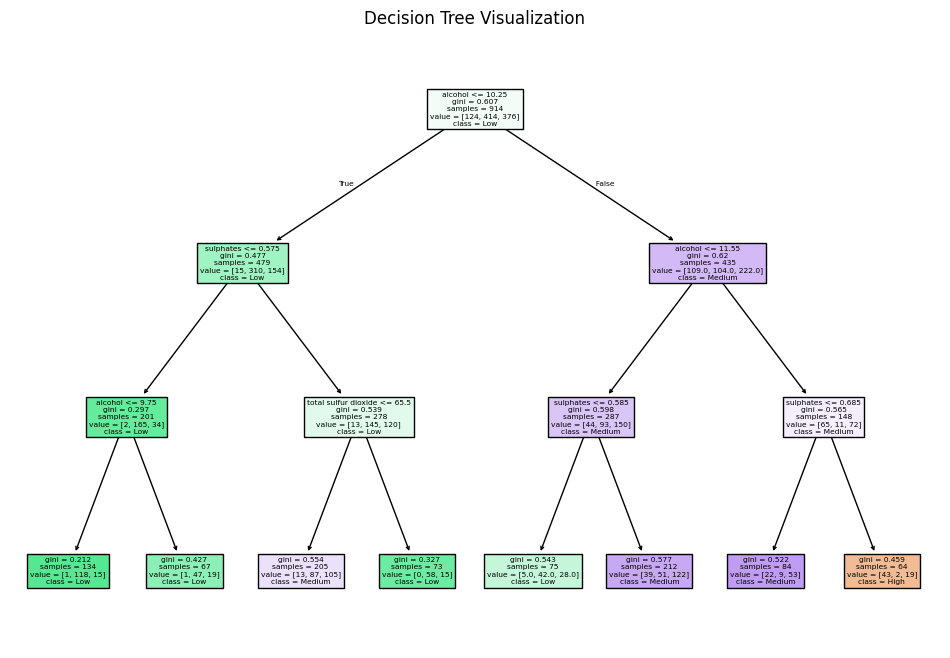

In [6]:
# Create a DecisionTreeClassifier instance
clf = DecisionTreeClassifier(criterion="gini", max_depth=3, splitter="best")

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(clf, feature_names=X.columns, class_names=clf.classes_.astype(str), filled=True)
plt.title("Decision Tree Visualization")
plt.show()

Tuning the Model, Max depth of 8 gives the best results

In [7]:
# Process of tuning the decision tree

def decisionTreeOutput(depth):
    clf = DecisionTreeClassifier(criterion="gini", max_depth=depth, splitter="best")
    # Train the classifier
    clf.fit(X_train, y_train)
    # Make predictions on the test set
    y_pred = clf.predict(X_test)
    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# For loop to iterate over different values of max_depth
depths = [6, 8, 10, 12]
for depth in depths:
    accuracy = decisionTreeOutput(depth)
    print(f"Max_depth: {depth}  Accuracy Score: {accuracy:.2f}")

Max_depth: 6  Accuracy Score: 0.63
Max_depth: 8  Accuracy Score: 0.66
Max_depth: 10  Accuracy Score: 0.64
Max_depth: 12  Accuracy Score: 0.63


In [8]:
# Create a DecisionTreeClassifier instance
clf = DecisionTreeClassifier(criterion="gini", max_depth=8, splitter="best")

# Train the classifier
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.66
Classification Report:
              precision    recall  f1-score   support

        High       0.61      0.54      0.58        35
         Low       0.81      0.66      0.72       108
      Medium       0.55      0.71      0.62        86

    accuracy                           0.66       229
   macro avg       0.66      0.64      0.64       229
weighted avg       0.68      0.66      0.66       229



I added the portion of code below to better see the absolute number of correct and wrong predictions

In [9]:
results = []
unique_labels = sorted(set(y_test))  # Unique actual labels

for label in unique_labels:
    # Get indices of samples with the current actual label
    indices = [i for i, actual in enumerate(y_test) if actual == label]
    
    # Extract corresponding predictions
    predictions = [y_pred[i] for i in indices]
    
    # Count occurrences of each predicted label
    prediction_counts = Counter(predictions)
    
    # Calculate correct predictions and percentage
    correct_predictions = prediction_counts.get(label, 0)  # Get count of correct predictions
    total_actual = len(indices)
    correct_percentage = (correct_predictions / total_actual) * 100 if total_actual > 0 else 0
    
    # Add row to results
    results.append({
        "Actual Label": label,
        "Count of Actual Samples": total_actual,
        "Predicted Labels": list(prediction_counts.keys()),
        "Counts of Predictions": list(prediction_counts.values()),
        "Correct Prediction %": f"{correct_percentage:.2f}%"  # Format as a percentage
    })

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Display the table
print(results_df)


  Actual Label  Count of Actual Samples     Predicted Labels  \
0         High                       35       [High, Medium]   
1          Low                      108  [Medium, Low, High]   
2       Medium                       86  [Medium, Low, High]   

  Counts of Predictions Correct Prediction %  
0              [19, 16]               54.29%  
1           [33, 71, 4]               65.74%  
2           [61, 17, 8]               70.93%  
